Subset.py

In [26]:
import pandas as pd

def subset(file_paths=[]):

    dataframes = [pd.read_csv(file) for file in file_paths]
    combined_df = pd.concat(dataframes, ignore_index=True)

    return combined_df

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset.py

In [27]:
from sklearn.model_selection import train_test_split
def dataset():
    file_paths = [
        '/content/drive/MyDrive/combined_features_with_date1.csv',
        # '/content/drive/MyDrive/combined_features_with_date2.csv',
        # '/content/drive/MyDrive/combined_features_with_date3.csv'
    ]

    Dataset = subset(file_paths=file_paths)

    TrainingData, TestData = train_test_split(Dataset, test_size=0.2, random_state=42)

    TrainingData.to_csv("TrainingData.csv", index=False)
    TestData.to_csv("TestData.csv", index=False)

    with open("features_info.txt", "w") as f:
        f.write("Features used:\n")
        for feature in Dataset.columns:
            f.write(f"{feature}\n")

    print("Datasets have been successfully split and saved as 'TrainingData.csv' and 'TestData.csv'.")
    print("Features info saved as 'features_info.txt'.")

    return TrainingData, TestData


neuralnet.py

In [29]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os

def build_model(input_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_size,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def prepare_dataset(data, batch_size=32, shuffle=True):
    X = data.drop(columns=["streamflow"]).values
    y = data["streamflow"].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size)

    return dataset, scaler

def train_nn(TrainingData, epochs=10, batch_size=32, checkpoint_dir="/content/checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)


    checkpoint_path = os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}.weights.h5")
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )

    # Remove unnecessary columns and NaNs
    if 'date' in TrainingData.columns:
        TrainingData = TrainingData.drop(columns=['date'])
    TrainingData = TrainingData.dropna()

    train_dataset, scaler = prepare_dataset(TrainingData, batch_size=batch_size, shuffle=True)


    input_size = TrainingData.drop(columns=["streamflow"]).shape[1]
    model = build_model(input_size)


    model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=train_dataset.take(20),
        callbacks=[checkpoint_callback],
        verbose=1
    )

    print("Model training complete.")
    return model, scaler

if __name__ == "__main__":

    # train_data, validation_data, test_data = dataset
    train_data = pd.read_csv('/content/TrainingData.csv').sample(10000, random_state=1)
    NNModel, scaler = train_nn(train_data)


Epoch 1/10
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 7.0806 - mae: 1.6215
Epoch 1: val_loss improved from inf to 8.09063, saving model to /content/checkpoints/model_epoch_01.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 7.9026 - mae: 1.6776 - val_loss: 8.0906 - val_mae: 1.6326
Epoch 2/10
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 5.8985 - mae: 1.5911
Epoch 2: val_loss improved from 8.09063 to 7.47118, saving model to /content/checkpoints/model_epoch_02.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.1574 - mae: 1.6028 - val_loss: 7.4712 - val_mae: 1.5684
Epoch 3/10
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.6809 - mae: 0.9391
Epoch 3: val_loss improved from 7.47118 to 6.94973, saving model to /content/checkpoints/model_epoch_03.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.4538 - mae: 1.3486 - val_loss: 6.9497 - val_mae: 1.5183
Epoch 4/10
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3910 - mae: 1.4315
Epoch 4: val_loss improved from 6.949

Time Series Forecasting:

Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

csv_path = '/content/drive/MyDrive/combined_features_with_date1.csv'

df = pd.read_csv(csv_path)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

date_time = df.pop('date')

# print(df.head())
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
snow_depth_water_equivalent_mean,7891952.0,42.414401,80.804755,0.00,0.00,0.23,47.76,806.96
surface_net_solar_radiation_mean,7891952.0,118.645158,81.195738,1.05,48.33,100.12,181.74,345.15
surface_net_thermal_radiation_mean,7891952.0,-51.749863,26.108172,-126.44,-72.34,-52.76,-31.24,32.79
surface_pressure_mean,7891952.0,98.336203,1.839745,88.06,97.18,98.48,99.69,104.50
temperature_2m_mean,7891952.0,4.651566,11.296679,-47.08,-2.95,4.95,14.13,31.33
dewpoint_temperature_2m_mean,7891952.0,0.395755,11.085597,-49.90,-6.93,0.99,9.37,25.66
u_component_of_wind_10m_mean,7891952.0,0.930433,2.058297,-15.35,-0.37,1.02,2.20,19.48
v_component_of_wind_10m_mean,7891952.0,0.092764,2.041131,-21.17,-1.23,0.09,1.44,16.05
volumetric_soil_water_layer_1_mean,7891952.0,0.328580,0.076177,0.06,0.27,0.34,0.39,0.76
volumetric_soil_water_layer_2_mean,7891952.0,0.328568,0.076529,0.07,0.27,0.34,0.39,0.76


In [3]:
import numpy as np


timestamp_s = date_time.map(pd.Timestamp.timestamp)


year = 365.2425 * 24 * 60 * 60  # seconds in a year

# Add sine and cosine transforms for yearly periodicity
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


print(df[['Year sin', 'Year cos']].head())

   Year sin  Year cos
0 -0.006752  0.999977
1  0.010450  0.999945
2  0.027650  0.999618
3  0.044841  0.998994
4  0.062019  0.998075


In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

train_df = df[0:int(n * 0.7)]  # First 70% of the data
val_df = df[int(n * 0.7):int(n * 0.9)]  # Next 20% of the data
test_df = df[int(n * 0.9):]  # Last 10% of the data

num_features = df.shape[1]

In [5]:
# Compute the mean and standard deviation of the training data
train_mean = train_df.mean()
train_std = train_df.std()

# Normalize the datasets
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [6]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [11]:
input_width = 7       # Number of days in the input
label_width = 1       # Predict 1 day
shift = 1             # Offset of 1 day into the future
label_columns = ["streamflow"]  # Target column

w2 = WindowGenerator(
    input_width=input_width,
    label_width=label_width,
    shift=shift,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=label_columns
)

print(w2)

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['streamflow']


In [12]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [13]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 8, 23)
Inputs shape: (3, 7, 23)
Labels shape: (3, 1, 1)


In [14]:
w2.example = example_inputs, example_labels

In [17]:
def plot(self, model=None, plot_col='surface_pressure_mean', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

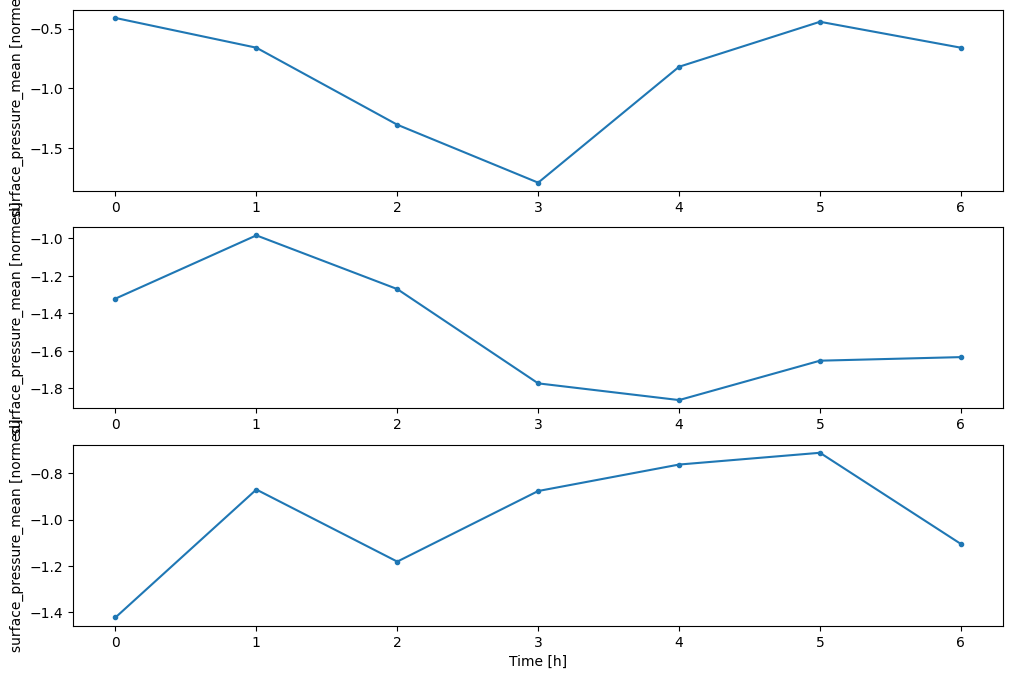

In [18]:
w2.plot()

In [19]:
def make_dataset(self, data):
    # Convert to NumPy array
    data = np.array(data, dtype=np.float32)

    # Create the dataset with overlapping windows
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,  # We handle labels separately in `split_window`
        sequence_length=self.total_window_size,  # Full window size
        sequence_stride=1,  # Slide by one step
        shuffle=True,  # Shuffle windows
        batch_size=32,  # Number of windows in each batch
    )

    # Map to (inputs, labels) using the `split_window` method
    ds = ds.map(self.split_window)

    return ds

# Add the method to the WindowGenerator class
WindowGenerator.make_dataset = make_dataset


In [20]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [21]:
w2.train.element_spec

(TensorSpec(shape=(None, 7, 23), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [22]:
seven_day_window = WindowGenerator(
    input_width=7,  # Number of days as input
    label_width=1,  # Single day to predict
    shift=1,        # Predict the day immediately following the 7-day input
    label_columns=['streamflow']  # Column to predict
)

# Print window configuration for verification
print(seven_day_window)

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['streamflow']


In [23]:
for example_inputs, example_labels in seven_day_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 7, 23)
Labels shape (batch, time, features): (32, 1, 1)


In [25]:
# Check one batch from the train dataset
for example_inputs, example_labels in seven_day_window.train.take(1):
    print(f"Example inputs: {example_inputs.numpy()}")
    print(f"Example labels: {example_labels.numpy()}")

Example inputs: [[[-0.49462876 -1.3195564   1.7585562  ...         nan -1.4013326
    0.19058107]
  [-0.49462876 -0.5209523   0.45760497 ...         nan -1.3978478
    0.21465853]
  [-0.49462876 -0.9391806   0.5632444  ...         nan -1.3939493
    0.23867248]
  ...
  [-0.49462876 -0.42613575  0.9815455  ...         nan -1.3849161
    0.28648144]
  [-0.49462876 -1.0007066   1.0720935  ...         nan -1.379784
    0.31026232]
  [-0.49462876 -0.7287101   0.15268245 ...         nan -1.3742436
    0.33395138]]

 [[-0.49462876  0.02797244  0.77568406 ... -0.3534259  -1.1245252
   -0.85756415]
  [-0.49462876  0.808205   -0.11083563 ... -0.39688316 -1.139111
   -0.83809334]
  [-0.49462876  0.5469356  -0.14411397 ... -0.41663647 -1.1533599
   -0.81837445]
  ...
  [-0.49462876  0.7101827  -0.6858545  ... -0.4403404  -1.1808293
   -0.77821606]
  [-0.49462876  1.1231092  -0.80581135 ... -0.4521924  -1.194042
   -0.7577884 ]
  [-0.49462876 -0.04563674  0.27380016 ... -0.4600937  -1.2069012
   -0

Baseline

In [26]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        # If label_index is not provided, return all inputs
        if self.label_index is None:
            return inputs
        # Extract the specific feature (e.g., streamflow)
        result = inputs[:, -1, self.label_index]
        return result[:, tf.newaxis, tf.newaxis]  # Shape: (batch_size, 1, 1)

In [27]:
# Assuming column_indices is a dictionary mapping column names to their indices
baseline = Baseline(label_index=column_indices['streamflow'])

# Compile the model with loss and metrics
baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [28]:
val_performance = {}
performance = {}

# Evaluate on validation and test datasets
val_performance['Baseline'] = baseline.evaluate(seven_day_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(seven_day_window.test, verbose=0, return_dict=True)

print("Validation Performance:", val_performance['Baseline'])
print("Test Performance:", performance['Baseline'])

49325/49325 ━━━━━━━━━━━━━━━━━━━━ 201s 4ms/step - loss: nan - mean_absolute_error: nan
Validation Performance: {'loss': nan, 'mean_absolute_error': nan}
Test Performance: {'loss': nan, 'mean_absolute_error': nan}


In [29]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['streamflow'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['streamflow']

Linear

In [32]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [33]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, seven_day_window)

val_performance['Linear'] = linear.evaluate(seven_day_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(seven_day_window.test, verbose=0, return_dict=True)

Epoch 1/20
172625/172637 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - mean_absolute_error: nan

Make a 1 day ahead prediction

In [ ]:
df = seven_day_window.test
last_7_days = df.tail(7)

last_7_days_data = last_7_days.drop(columns='streamflow').values

last_7_days_data = last_7_days_data.reshape((1,7,last_7_days_data.shape[1]))

prediction = linear.predict(last_7_days_data)

print("predicted streamflow for the next day: ", prediction)

Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, seven_day_window)

val_performance['Dense'] = dense.evaluate(seven_day_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(seven_day_window.test, verbose=0, return_dict=True)